In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
data_path = '/content/drive/MyDrive/Class1'

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img
import os
import glob
import imageio.v3 as iio
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img
import os

from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import StratifiedKFold
from keras.applications import ResNet50, DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Input
from keras.models import Model

In [ ]:
def load_file(file_path, label):
    file_path =file_path

    folder_name = file_path.split("/")[-1]

    out_list = []

    # Load every file .png format
    for image_path in glob.glob(file_path + "/*.PNG"):
        # Read image file
        image = iio.imread(image_path)

        # Declare temporary dict dtype
        temp = {}

        # Set the file name
        temp["name"] = image_path.split("/")[-1]

        # Set the file label, 0 for non defect. 1 for defect
        temp["label"] = label
        # There are somes images are tensor dtype
        # Thus I fix by selecting only a tensor index zero
        try:
            temp["data"] = image[:,:,0].astype("int")
        except:
            # Normal case
            temp["data"] = image.astype("int")

        # Append temp into output list
        out_list.append(temp)

    # Print process status by checking size of output list
    if len(out_list) == 0:
        print("loading files from folder: {} is   failed".format(folder_name))
    else:
        print("loading file from folder: {} is successful".format(folder_name))

    # Convert list into numpy array dtype
    return np.array(out_list)

In [ ]:
defect_images_path = data_path + '/defect'
non_defect_images_path = data_path + '/non-defect'

defect_images = load_file(defect_images_path, 1)
non_defect_images = load_file(non_defect_images_path, 0)

loading file from folder: defect is successful
loading file from folder: non-defect is successful


In [ ]:
import tensorflow as tf
import numpy as np
import os
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import StratifiedKFold
from keras.applications import ResNet50, DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Input
from keras.models import Model

# Function to load images from a directory and label them
def load_file(image_dir, label, image_size=(512, 512)):
    images = []
    if not os.path.exists(image_dir):
        raise FileNotFoundError(f"The directory {image_dir} does not exist.")

    for filename in os.listdir(image_dir):
        # Load the image in grayscale mode
        img = load_img(os.path.join(image_dir, filename), color_mode='grayscale', target_size=image_size)
        img_array = img_to_array(img)
        images.append({'data': img_array, 'label': label})
    return np.array(images)

# Set the correct data path
data_path = data_path # Update this to the correct path
defect_images_path = os.path.join(data_path, 'defect')
non_defect_images_path = os.path.join(data_path, 'non-defect')

# Load defect and non-defect images
try:
    defect_images = load_file(defect_images_path, 1)
    non_defect_images = load_file(non_defect_images_path, 0)
except FileNotFoundError as e:
    print(e)
    # Exit or handle the error as needed
    exit()

# Shuffle the images
np.random.shuffle(defect_images)
np.random.shuffle(non_defect_images)

# Balance the classes
#class_size = min(defect_images.shape[0], non_defect_images.shape[0])

# Combine the balanced datasets
dataset = np.concatenate((defect_images, non_defect_images))

# Create an empty matrix X and vector y
X = np.empty([dataset.shape[0], 512, 512, 1]).astype(np.float32)
y = np.empty(dataset.shape[0]).astype(np.int32)

# Assign the data to X and y
for i in range(dataset.shape[0]):
    X[i] = dataset[i]['data']
    y[i] = dataset[i]['label']

# Convert X to a TensorFlow tensor
X = tf.convert_to_tensor(X)

# Convert grayscale images to RGB and resize to (224, 224)
X_rgb = tf.image.grayscale_to_rgb(X)
X_rgb = tf.image.resize(X_rgb, [224, 224])

# Convert back to numpy array for indexing
X_rgb = X_rgb.numpy()

# Display size of the labels
print(np.unique(y, return_counts=True))

<ipython-input-7-37ec3b7aeb18>:49: RuntimeWarning: invalid value encountered in cast
  y = np.empty(dataset.shape[0]).astype(np.int32)


(array([0, 1], dtype=int32), array([1068,  150]))


In [ ]:
from keras.layers import Dropout, BatchNormalization

def create_smaller_hybrid_model(image_shape=(224, 224, 3), print_summary=False):
    input_tensor = Input(shape=image_shape)

    # Smaller ResNet (ResNet50 but truncated)
    resnet_base = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
    for layer in resnet_base.layers[:100]:  # Freeze first 100 layers
        layer.trainable = False
    resnet_out = GlobalAveragePooling2D()(resnet_base.output)

    # Smaller DenseNet (DenseNet121 but truncated and renamed)
    densenet_base = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_tensor)
    for layer in densenet_base.layers[:400]:  # Freeze first 400 layers
        layer._name = "dense_" + layer.name  # Rename each layer in DenseNet to avoid conflicts
        layer.trainable = False
    densenet_out = GlobalAveragePooling2D()(densenet_base.output)

    # Concatenate features
    combined_features = Concatenate()([resnet_out, densenet_out])

    # Dense layers for classification with Dropout and BatchNormalization
    x = Dense(512, activation='relu')(combined_features)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_tensor, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Show the CNN model detail
    if print_summary:
        model.summary()

    return model


In [ ]:
import tensorflow as tf
import numpy as np
import os
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import StratifiedKFold
from keras.applications import ResNet50, DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D, Concatenate, Input
from keras.models import Model

kfold_splits = 4
n_epoch = 5
batch_size = 10
skf = StratifiedKFold(n_splits=kfold_splits, shuffle=True)

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

for fold, (train_indices, val_indices) in enumerate(skf.split(X_rgb, y)):
    print(f'Training on fold {fold+1}/{kfold_splits}...')

    # Get the train and validation data for the current fold
    xtrain, xval = X_rgb[train_indices], X_rgb[val_indices]
    ytrain, yval = y[train_indices], y[val_indices]

    # Print number of samples per class in the current fold
    print(f'ytrain: number of samples each class: {np.unique(ytrain, return_counts=True)}')
    print(f'yval: number of samples each class: {np.unique(yval, return_counts=True)}')

    # Create a new model instance
    model = create_smaller_hybrid_model(print_summary=(fold == 0))

    print(f'Training new iteration on {xtrain.shape[0]} training samples, {xval.shape[0]} validation samples, this may take a while...')

    # Train the model
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'resnet_densenet_model_fold_{fold+1}.h5', save_best_only=True, monitor='val_loss')

    history = model.fit(
    datagen.flow(xtrain, ytrain, batch_size=batch_size),
    epochs=n_epoch,
    validation_data=(xval, yval),
    callbacks=[early_stopping, model_checkpoint]
)

    print('— ' * 20)

Training on fold 1/4...
ytrain: number of samples each class: (array([0, 1], dtype=int32), array([801, 112]))
yval: number of samples each class: (array([0, 1], dtype=int32), array([267,  38]))
29084464/29084464 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 dense_input_1 (InputLayer)  [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 dense_zero_padding2d (Zero  (None, 230, 230, 3)          0         ['dense_input_1[0][0]']       
 Padding2D)                                                                                       
                                                                                                  
 dense_conv1/conv (Conv2D)   (Non

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


92/92 [==============================] - 63s 329ms/step - loss: 0.6837 - accuracy: 0.7076 - val_loss: 0.4014 - val_accuracy: 0.8787
Epoch 2/5
92/92 [==============================] - 11s 123ms/step - loss: 0.4560 - accuracy: 0.8532 - val_loss: 0.4084 - val_accuracy: 0.8754
Epoch 3/5
92/92 [==============================] - 11s 122ms/step - loss: 0.4250 - accuracy: 0.8697 - val_loss: 0.5169 - val_accuracy: 0.8656
Epoch 4/5
92/92 [==============================] - 13s 143ms/step - loss: 0.3493 - accuracy: 0.8740 - val_loss: 0.0447 - val_accuracy: 0.9934
Epoch 5/5
92/92 [==============================] - 11s 123ms/step - loss: 0.2977 - accuracy: 0.8970 - val_loss: 1.9124 - val_accuracy: 0.6098
— — — — — — — — — — — — — — — — — — — — 
Training on fold 2/4...
ytrain: number of samples each class: (array([0, 1], dtype=int32), array([801, 112]))
yval: number of samples each class: (array([0, 1], dtype=int32), array([267,  38]))
Training new iteration on 913 training samples, 305 validation sa

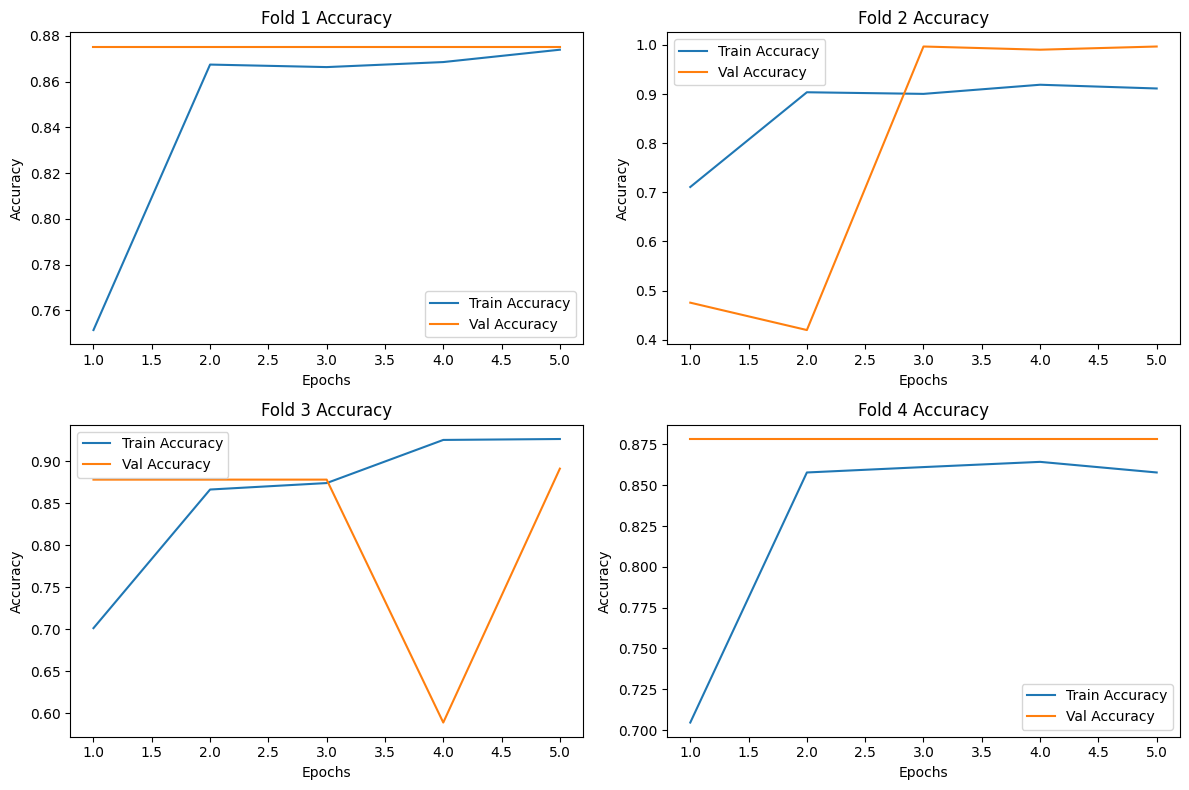

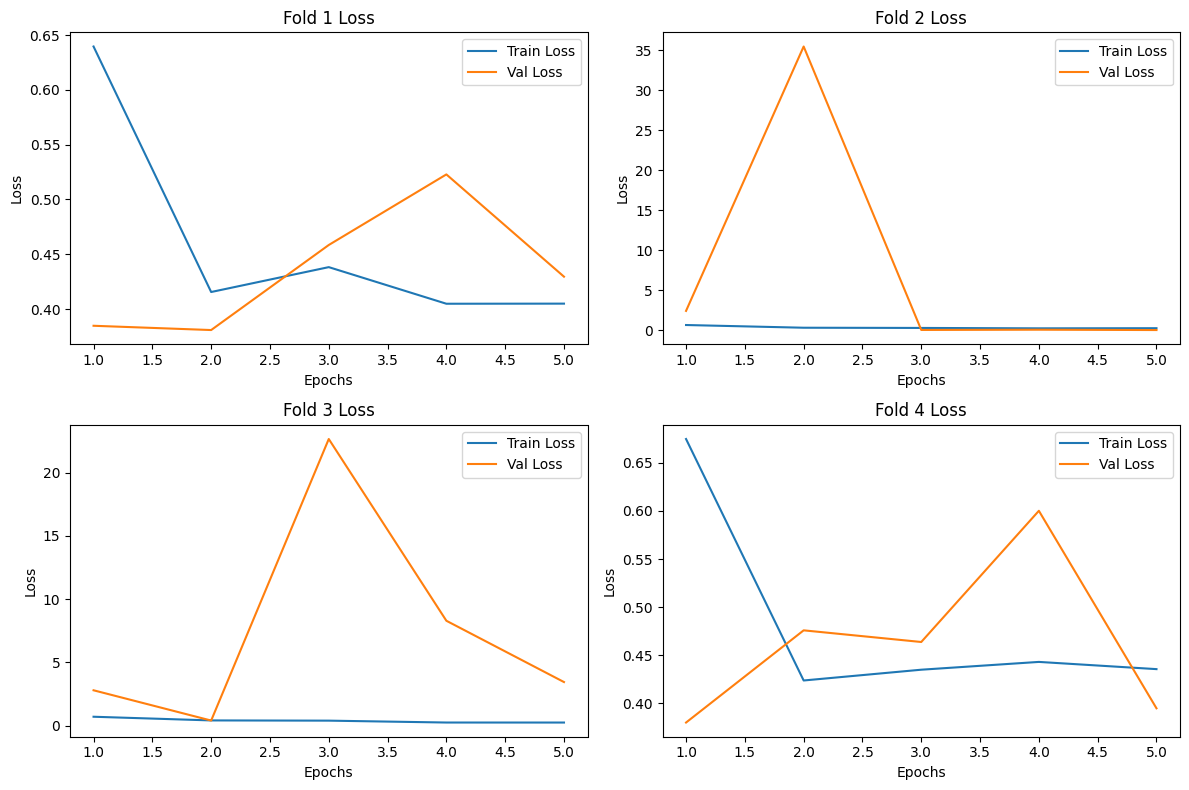

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

# Metrics for each fold
fold_metrics = {
    1: {'train_loss': [0.6395, 0.4155, 0.4382, 0.4048, 0.4049],
        'train_acc': [0.7514, 0.8675, 0.8664, 0.8686, 0.8740],
        'val_loss': [0.3847, 0.3808, 0.4584, 0.5228, 0.4295],
        'val_acc': [0.8754, 0.8754, 0.8754, 0.8754, 0.8754]},
    2: {'train_loss': [0.6341, 0.2951, 0.2689, 0.2187, 0.2360],
        'train_acc': [0.7108, 0.9036, 0.9003, 0.9189, 0.9113],
        'val_loss': [2.4011, 35.4737, 0.0170, 0.0484, 0.0053],
        'val_acc': [0.4754, 0.4197, 0.9967, 0.9902, 0.9967]},
    3: {'train_loss': [0.6979, 0.4069, 0.3893, 0.2406, 0.2392],
        'train_acc': [0.7013, 0.8665, 0.8742, 0.9256, 0.9267],
        'val_loss': [2.7896, 0.3965, 22.6531, 8.2855, 3.4402],
        'val_acc': [0.8783, 0.8783, 0.8783, 0.5888, 0.8914]},
    4: {'train_loss': [0.6747, 0.4238, 0.4350, 0.4431, 0.4356],
        'train_acc': [0.7046, 0.8578, 0.8611, 0.8643, 0.8578],
        'val_loss': [0.3801, 0.4759, 0.4638, 0.6001, 0.3949],
        'val_acc': [0.8783, 0.8783, 0.8783, 0.8783, 0.8783]}
}

# Plot training and validation metrics for each fold
plt.figure(figsize=(12, 8))

for i in range(1, 5):
    fold_metrics_i = fold_metrics[i]
    epoch = np.arange(1, 6)

    # Plot training accuracy
    plt.subplot(2, 2, i)
    plt.plot(epoch, fold_metrics_i['train_acc'], label='Train Accuracy')
    plt.plot(epoch, fold_metrics_i['val_acc'], label='Val Accuracy')
    plt.title(f'Fold {i} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))

for i in range(1, 5):
    fold_metrics_i = fold_metrics[i]
    epoch = np.arange(1, 6)

    # Plot training loss
    plt.subplot(2, 2, i)
    plt.plot(epoch, fold_metrics_i['train_loss'], label='Train Loss')
    plt.plot(epoch, fold_metrics_i['val_loss'], label='Val Loss')
    plt.title(f'Fold {i} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

plt.tight_layout()
plt.show()
